In [1]:
import gpytorch
import matplotlib.pyplot as plt
import torch

/Users/gabestechschulte/miniforge3/envs/bayesopt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_x = torch.tensor(
    [
        [1 / 2, 1 / 2, 0, 0],
        [1 / 3, 1 / 3, 1 / 3, 0],
        [0, 1 / 2, 1 / 2, 0],
        [0, 1 / 3, 1 / 3, 1 / 3]
    ]
)
train_y = torch.tensor([192.08, 258.30, 187.24, 188.54])

In [3]:
train_x.shape

torch.Size([4, 4])

In [4]:
# normalize train_y
train_y = (train_y - train_y.mean()) / train_y.std()
train_y

tensor([-0.4183,  1.4974, -0.5583, -0.5207])

In [5]:
class BaseGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(BaseGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [6]:
# initialize likelihood and model
lengthscale = 1
noise = 1e-4

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = BaseGPModel(train_x, train_y, likelihood)

model.covar_module.lengthscale = lengthscale
model.likelihood.noise = noise

# enable prediction mode
model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [7]:
grid_x = torch.linspace(0, 1, 101)
grid_x1, grid_x2 = torch.meshgrid(grid_x, grid_x)
xs = torch.vstack([
    grid_x1.flatten(),
    grid_x2.flatten(),
    torch.zeros(101**2),
    torch.zeros(101**2)
]).transpose(-1, -2)

/Users/gabestechschulte/miniforge3/envs/bayesopt/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1695391829313/work/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
xs.shape

torch.Size([10201, 4])

In [9]:
with torch.no_grad():
    predictive_distribution = likelihood(model(xs))
    predictive_mean = predictive_distribution.mean
    predictive_std = predictive_distribution.stddev

In [12]:
predictive_mean.detach().reshape(101, 101).transpose(-1, -2).shape

torch.Size([101, 101])

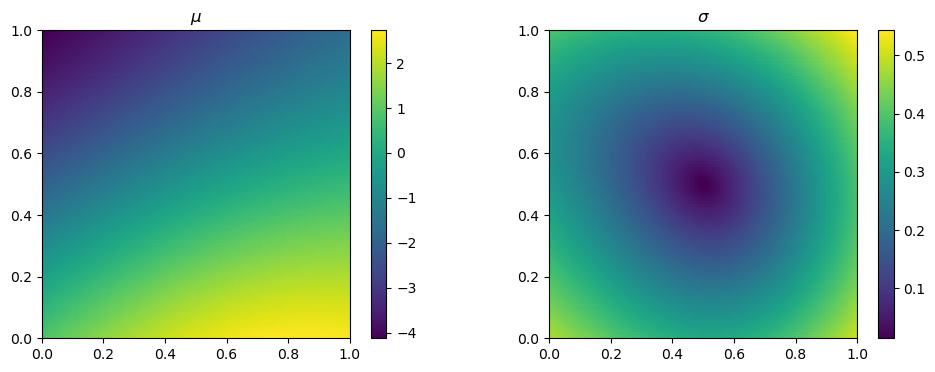

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

c = ax[0].imshow(
    predictive_mean.detach().reshape(101, 101).transpose(-1, -2),
    origin="lower",
    extent=(0, 1, 0, 1),
)
ax[0].set_title("$\\mu$")
plt.colorbar(c, ax=ax[0])

c = ax[1].imshow(
    predictive_std.detach().reshape(101, 101).transpose(-1, -2),
    origin="lower",
    extent=(0, 1, 0, 1),
)
plt.colorbar(c, ax=ax[1])
ax[1].set_title("$\\sigma$");